# GEOL 7720 - Exercise 5
### November 2$^{nd}$
### Ian Deniset 

## Objective 
Using a provided group of travel times generated from a set survey geometry, invert for a subsurface velocity model using explicit regularization.

## Theory
The ideal formulation of a geophysical inverse problem would allow for both model regularization and honoring of noisy data.  To achieve this, an under determined or mixed determined problem needs to posed as an over determined problem with model regularization.  This gives the following combined objective function:

$\phi = ||W_M \big(m-m_0\big)||^2 + \mu ||W_D \big(d-Am\big)||^2$

Here $\mu$ is a trade-off parameter which specifies the proportion of how much the data misfit is honored in comparison to the model regularization.  For example, a higher $\mu$ value would give a closer fit to the data but result in a more complex and rough model if smoothing was being used.  

There are a number of ways to find the trade-off parameter value, the most common of which is a guess and check method where a series of inversions are performed with varying values of $\mu$ until the "correct" value is found.  However, if the error on the data is known with a reasonable degree of certainty, then $\mu$ can be found when the data misfit (sum of squares error) is equal to the number of data points.

To apply this method to an inverse problem using multiple model regularizations, the easiest approach is to use what is called "explicit regularization".  To do this, we can combine the misfit and an arbitrary number of regularizations into augmented matrices of the form:

$\begin{bmatrix} W_DA \\ \alpha_1W_M^1 \\ \alpha_2W_M^2 \\ \vdots \\ \alpha_jW_M^j \end{bmatrix}
m= \begin{bmatrix} W_Dd \\ \alpha_1W_M^1 m_0 \\ \alpha_2W_M^2 m_0 \\ \vdots \\ \alpha_jW_M^j m_0 \end{bmatrix}$

where $\alpha$ is a weighting applied to the model regularizations being used.

In the case of the tomography problem being solved below, the matrices would take the form:

$\begin{bmatrix} W_DA \\ \alpha_1Flattening \\ \alpha_2Smoothing \\ \alpha_3Damping \end{bmatrix}
m= \begin{bmatrix} W_Dd \\ \alpha_1 0 \\ \alpha_2 0 \\ \alpha_3 m_0 \end{bmatrix}$

Basically this is saying solve for the model while honoring the data and errors, while also keeping it as flat and smooth as possible and close to a specified base model.  How each of the regularizations is weighted depends on the choice of $\alpha$. 

The resultant model from solving the above explicit regularization will have a given resolution matrix $R$ determining how sensitive each portion of the model is to structure and is given by:

$R = \big(B^TB \big)^{-1}A^TW_D^TW_DA$

where $B$ is the augmented $A$ matrix (left hand side of the equation above) containing the model regularizations such as damping, flattening, and smoothing.

Each column of the resolution matrix represents the output models response to a unit perturbation input.

### Setting up the Tomography Problem
In cross-hole tomography, travel times from shot to receiver depend exclusively on velocity ($v=1/s$).  If it is assumed that the ray path does not depend on said velocity, then the travel time of a ray along its path becomes linear.  Dividing up the earth between the shots and receivers into an equal grid of cells thus allows the total travel time of each ray to be given by:

$t_i=\sum^N_{j=1}l_{ij}s_j = \sum^N_{j=1}A_{ij}s_j$

Where $l_{ij}$ is the length of ray $i$ in the $j^{th}$ cell and represents a sensitivity matrix that gives the travel time of each ray as an inner product with the cell slowness.

## Solution
First lets load the data and investigate.

In [1]:
#load in usual modules
import numpy as np
import matplotlib.pyplot as plt
import oct2py
%matplotlib inline

#oct2py is a module allowing for integration of octave and python sessions
oc = oct2py.Oct2Py()

Load in the data file provided and investigate

In [2]:
#initialize octave session and load provided data 
oc.eval('load data.mat')
oc.eval('whos')

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        ans         1x1                         12  cell
        data      138x1                       1104  double
        err         1x138                     1104  double
        rec_z       1x23                       184  double
        shot_z      1x6                         48  double
        xmax        1x1                          8  double
        zmax        1x1                          8  double

Total is 308 elements using 2468 bytes



In [3]:
oc.eval('xmax,zmax')

xmax =  100
zmax =  120


As can be seen above, the geometry of the survey is 6 shots spaced evenly to a depth of 120 meters with 23 receivers a distance of 100 meters away spaced evenly to a depth of 120 meters, providing a total of 138 recorded travel times.

The first step for investigation will be to create a sensitivity matrix of the model using the provided script.  The grid spacing to create the $A$ matrix will be 50x60.  These values provide a fine enough grid of the subsurface without being too large that computations become slow and cumbersome.  The spacing also keeps each subsurface cell equal in dimension.

The sensitivity matrix is created and displayed below:

In [4]:
#create matrix of sensitivities in Octave and pull it to python
oc.eval('warning("off")')    #turn off annoying divide by zero errors

oc.eval('nx=50;')
oc.eval('nz=60;')
oc.eval('A = crosshole_partials(shot_z,rec_z,xmax,zmax,nx,nz);')
A = oc.pull('A')
print('The shape of the sensitivity matrix is:', A.shape)

The shape of the sensitivity matrix is: (138, 3000)


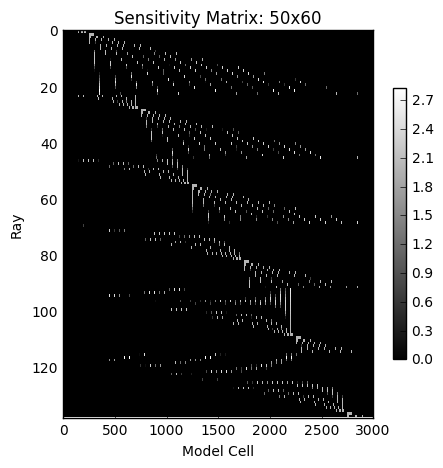

In [5]:
#plot the resulting 'A' matrix
fig, ax = plt.subplots(1,1,figsize=(5,5))

im = ax.imshow(A, cmap='gray', interpolation='None', aspect='auto')
fig.colorbar(im, ax = ax, shrink=0.7)
ax.set_xlabel('Model Cell')
ax.set_ylabel('Ray')
ax.set_title('Sensitivity Matrix: 50x60')
   
plt.show()

As can be seen, the sensitivity matrix is a 138 x (50 x 60).  Each row represents the length of a ray in each model cell; thus, the total length for each ray is given by a summation across each row.  This can be used to calculate the average slowness or velocity of the subsurface to provide a starting base model.

In [6]:
data = oc.pull('data')       #pull ray travel times

rayLength = np.sum(A,1)
rayVels = rayLength.T / data.T
print('The mean subsurface velocity is: ', np.mean(rayVels))

The mean subsurface velocity is:  1063.31069986


With the mean velocity determined and the sensitivity matrix obtained, a very general model can be inverted by using damping only to get a first pass idea of subsurface structure.

The system of equations will look as follows:

$\begin{bmatrix} A \\ \alpha_1Damping  \end{bmatrix}
m= \begin{bmatrix} d \\ \alpha_1 m_0 \end{bmatrix}$


In [7]:
#create initial subsurface model by taking 1/Velavg
initVelmod = 1 / 1200 

In [8]:
#set a range of damping values to investigate
dampingValues = [0.001,0.01,1,10,100,1000]
model_DampOnly = []

#create augmented matrix and invert for each damping value
for dampVal in range(len(dampingValues)):

    #set up damping matrix with weighting applied
    eyeDamp = dampingValues[dampVal]*np.identity(len(A[0,:]))
    augA = np.concatenate((A,eyeDamp))

    #set up initial model with weight applied
    dampingModel = dampingValues[dampVal]*initVelmod*np.ones((len(A[0,:]),1))
    augD = np.concatenate((data,dampingModel))

    #invert; note that lstsq returns several values - solution contained in the first 
    ans = np.linalg.lstsq(augA,augD)
    model_DampOnly.append(ans[0])
    
    print('Current Damping Value: ', dampingValues[dampVal])

Current Damping Value:  0.001
Current Damping Value:  0.01
Current Damping Value:  1
Current Damping Value:  10
Current Damping Value:  100
Current Damping Value:  1000


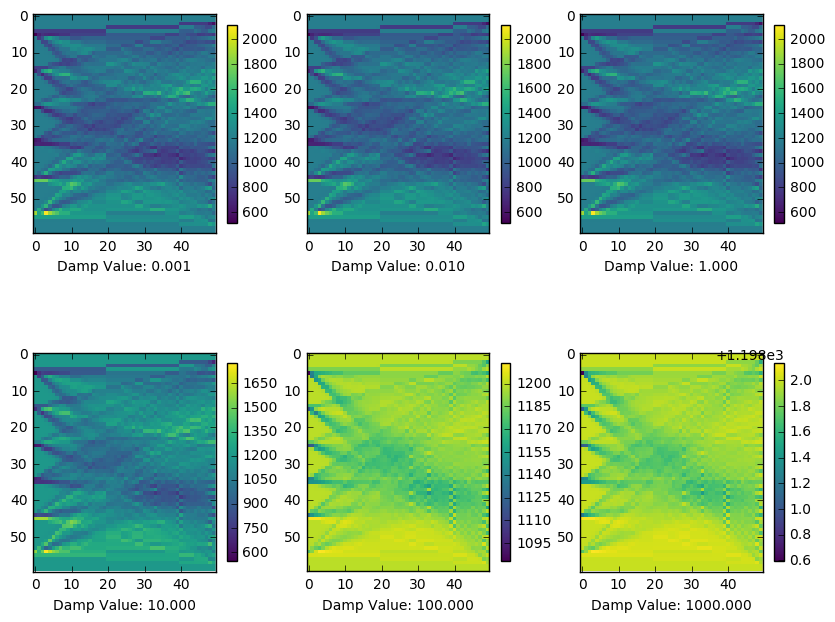

In [9]:
#plot the resulting models
fig, ax = plt.subplots(2,3,figsize=(10,8))
i=0
for row in range(2):
    for col in range(3):
        im = ax[row,col].imshow(np.reshape(1/model_DampOnly[i],(60,50)), cmap='viridis', interpolation='None')
        fig.colorbar(im, ax = ax[row,col], shrink=0.7)
        ax[row,col].set_xlabel('Damp Value: %0.3f' %dampingValues[i])
        i += 1    

plt.show()

As expected, increasing the base model damping weight pushes the solution closer to base model velocity values.  It can also be seen that without smoothing included, the model tends to provide velocity variations only along ray paths.

The next step is to weight the data by the inverse of the error giving the new set of normal equations to be:

$\begin{bmatrix} W_DA \\ \alpha_1Damping \end{bmatrix}
m= \begin{bmatrix} W_Dd \\ \alpha_1m_0 \end{bmatrix}$

Where $W_D$ is the weighting matrix formed from the provided data errors and has the form:

$W_D = \begin{bmatrix} 1/e_1 & 0 & \cdots & 0 \\ 0 & 1/e_2 & \cdots & 0 \\ 
\vdots & \vdots & \ddots & \vdots \\ 0&0&\cdots&1/e_N \end{bmatrix}$



In [10]:
error = oc.pull('err')      #pull error

#data weighting matrix; inverse of error
dataWeighting = np.zeros((len(data),len(data)))

for i in np.arange(0,len(data)):
    dataWeighting[i,i] = 1/error[0][i]
    
    
#create weighted data and sensitivity matrices
A_weighted = dataWeighting @ A
data_weighted = dataWeighting @ data

Now create new augmentted matricies and solve again using damping only:

In [11]:
initVelmod = 1/1200

#set a range of damping values to investigate
dampingValues = [0.001,0.01,1,100,1000,10000]
model_DampWeighted = []

#create augmented matrix and invert for each damping value
for dampVal in range(len(dampingValues)):

    #set up damping matrix with weighting applied
    eyeDamp = dampingValues[dampVal]*np.identity(len(A[0,:]))
    augA = np.concatenate((A_weighted,eyeDamp))

    #set up initial model with weight applied
    dampingModel = dampingValues[dampVal]*initVelmod*np.ones((len(A[0,:]),1))
    augD = np.concatenate((data_weighted,dampingModel))

    #invert; note that lstsq returns several values - solution contained in the first 
    ans = np.linalg.lstsq(augA,augD)
    model_DampWeighted.append(ans[0])

    
    print('Current Damping Value: ', dampingValues[dampVal])

Current Damping Value:  0.001
Current Damping Value:  0.01
Current Damping Value:  1
Current Damping Value:  100
Current Damping Value:  1000
Current Damping Value:  10000


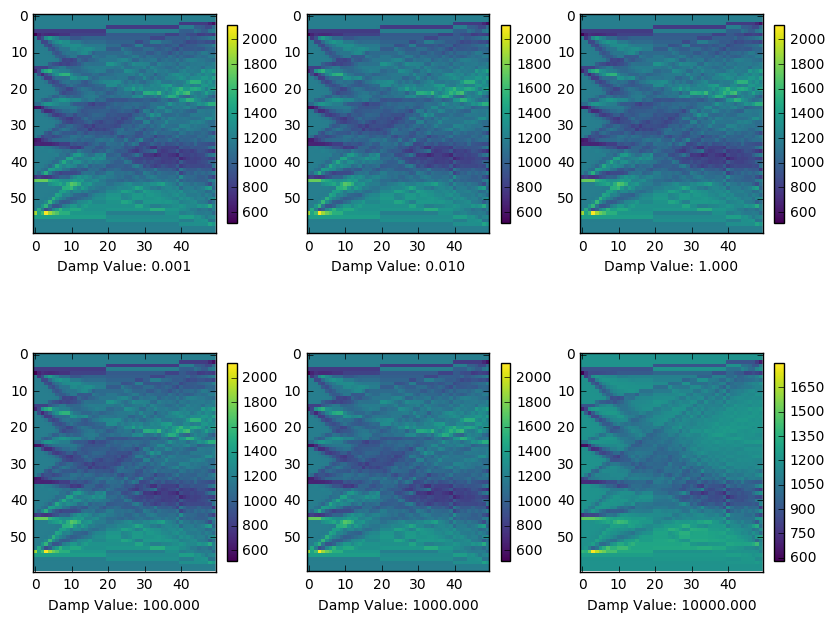

In [12]:
#plot the resulting models
fig, ax = plt.subplots(2,3,figsize=(10,8))
i=0
for row in range(2):
    for col in range(3):
        im = ax[row,col].imshow(np.reshape(1/model_DampWeighted[i],(60,50)), cmap='viridis', interpolation='None')
        fig.colorbar(im, ax = ax[row,col], shrink=0.7)
        ax[row,col].set_xlabel('Damp Value: %0.3f' %dampingValues[i])
        i += 1    

plt.show()

Again, as expected, the output model tends towards the base value with increased damping weight.  However, it should be noted that the effect of the damping is much more subtle now that the data has been weighted by its errors; going forward, the weighting applied to further model regularizations will also need to be increased.

### Addition of Flattening and Smoothing
To achieve a final output model of the subsurface, two more model regularizations will need to be added: damping and smoothing.  In tomography, it is common for smoothing to dominate as the rays only sample a small portion of the subsurface subsequently leading to a rough model which can be seen above.  Thus, when posing the set of normal equations, weighting will favor mostly smoothing with small amounts of proportional flattening and damping.

The new set of normal equations will become:

$\begin{bmatrix} W_DA \\ \alpha_1Flattening \\ \alpha_2Smoothing \\ \alpha_3Damping \end{bmatrix}
m= \begin{bmatrix} W_Dd \\ \alpha_1 0 \\ \alpha_2 0 \\ \alpha_3 m_0 \end{bmatrix}$

...giving both smoothing and damping weights proportional to smoothing gives...

$\begin{bmatrix} W_DA \\ \alpha_2 \times \alpha_1Flattening \\ \alpha_2Smoothing \\ \alpha_2 \times \alpha_3Damping \end{bmatrix}
m= \begin{bmatrix} W_Dd \\ 0 \\ 0 \\ \alpha_2 \times \alpha_3 m_0 \end{bmatrix}$

The flattening and smoothing matrices are formed below using the provided functions:

In [13]:
#create smoothing matrix in Octave and pull it to python
oc.eval('smoother = crosshole_smoother(xmax,zmax,nx,nz);')
smoother = oc.pull('smoother')
print('The shape of the smoothing matrix is:', smoother.shape)

#create flattening matrix in Octave and pull it to python
oc.eval('flattener = crosshole_flattener(xmax,zmax,nx,nz);')
flattener = oc.pull('flattener')
print('The shape of the flattening matrix is:', flattener.shape)

The shape of the smoothing matrix is: (5780, 3000)
The shape of the flattening matrix is: (5890, 3000)


Now create new augmented matrices and invert using different smoothing weights:

In [14]:
%%time

initVelmod = 1/1075

#set a range of smoothing values to investigate; keep damping and flattening to a min
smoothingValues = np.asarray([0.01,0.1,10,100,1000,10000])*100
model_Smoothing = []

#create augmented matrix and invert for each smoothing value
for smoothVal in range(len(smoothingValues)):

    #set up damping, flattening, and smoothing matrix; weight damping and flattening in proportion to smoothing
    eyeDamp = 0.01*smoothingValues[smoothVal]*np.identity(len(A[0,:]))
    weightedFlatt = 0.08*smoothingValues[smoothVal]*flattener
    weightedSmooth = smoothingValues[smoothVal]*smoother
    
    augA = np.concatenate((A_weighted,eyeDamp,weightedFlatt,weightedSmooth))

    #set up initial model with weighting and create smoothing/flattening 'zero' matrices
    dampingModel = 0.01*smoothingValues[smoothVal]*initVelmod*np.ones((len(A[0,:]),1))
    flattTrend = np.zeros((len(flattener),1))
    smoothTrend = np.zeros((len(smoother),1))
    
    augD = np.concatenate((data_weighted,dampingModel,flattTrend,smoothTrend))

    #invert; note that lstsq returns several values - solution contained in the first 
    ans = np.linalg.lstsq(augA,augD)
    model_Smoothing.append(ans[0])

    
    print('Current Smoothing Value: ', smoothingValues[smoothVal], '; Damping and Flattening of: ', 
         smoothingValues[smoothVal]*0.01, ' and ', smoothingValues[smoothVal]*0.08)

Current Smoothing Value:  1.0 ; Damping and Flattening of:  0.01  and  0.08
Current Smoothing Value:  10.0 ; Damping and Flattening of:  0.1  and  0.8
Current Smoothing Value:  1000.0 ; Damping and Flattening of:  10.0  and  80.0
Current Smoothing Value:  10000.0 ; Damping and Flattening of:  100.0  and  800.0
Current Smoothing Value:  100000.0 ; Damping and Flattening of:  1000.0  and  8000.0
Current Smoothing Value:  1000000.0 ; Damping and Flattening of:  10000.0  and  80000.0
CPU times: user 3min 21s, sys: 3.19 s, total: 3min 25s
Wall time: 1min 29s


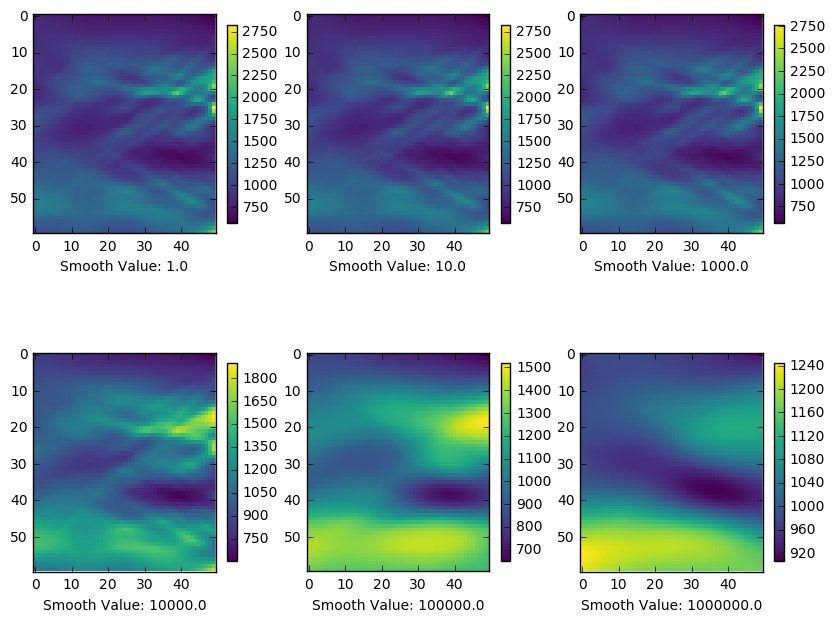

In [15]:
#plot the resulting models
fig, ax = plt.subplots(2,3,figsize=(10,8))
i=0
for row in range(2):
    for col in range(3):
        im = ax[row,col].imshow(np.reshape(1/model_Smoothing[i],(60,50)), cmap='viridis', interpolation='None')
        fig.colorbar(im, ax = ax[row,col], shrink=0.7)
        ax[row,col].set_xlabel('Smooth Value: %0.1f' %smoothingValues[i])
        i += 1    

plt.show()

Looking at the plots above, it can be seen that the effect of smoothing only really sets in between 10,000 and 100,000 with all other models being too rough (can see individual ray paths).  A smoothing value of 1,000,000 is too aggressive as possible structure is likely being lost and the output velocity values are being pushed too close to that of the base model due to the proportionally scaled damping value.

To get a better handle on the appropriate weighting value to use, a trade-off curve can be formed by investigating several smoothing weights and the associated model roughness and misfit.

### Trade-Off Curve
Generate several models using varying smoothing weights:

In [16]:
smoothingVals = np.asarray([0.01,10,100,500,825,1000,2000,3000])*100

modelSmoothed = []

for i in range(len(smoothingVals)):
    #set up damping, flattening, and smoothing matrices; weight damping and smoothing by 1/4 smoothing
    eyeDamp = 0.01*smoothingVals[i]*np.identity(len(A[0,:]))
    weightedFlatt = 0.08*smoothingVals[i]*flattener
    weightedSmooth = smoothingVals[i]*smoother
    
    augA = np.concatenate((A_weighted,eyeDamp,weightedFlatt,weightedSmooth))

    #set up initial model with weighting and create smoothing/flattening 'zero' matrices
    dampingModel = 0.01*smoothingVals[i]*initVelmod*np.ones((len(A[0,:]),1))
    flattTrend = np.zeros((len(flattener),1))
    smoothTrend = np.zeros((len(smoother),1))
    
    augD = np.concatenate((data_weighted,dampingModel,flattTrend,smoothTrend))

    #invert; note that lstsq returns several values - solution contained in the first 
    ans = np.linalg.lstsq(augA,augD)
    modelSmoothed.append(ans[0])

    
    print('Current Smoothing Value: ', smoothingVals[i], ';Damping and Flattening of: ', 
         smoothingVals[i]*0.01, ' and ', smoothingVals[i]*0.08)

Current Smoothing Value:  1.0 ;Damping and Flattening of:  0.01  and  0.08
Current Smoothing Value:  1000.0 ;Damping and Flattening of:  10.0  and  80.0
Current Smoothing Value:  10000.0 ;Damping and Flattening of:  100.0  and  800.0
Current Smoothing Value:  50000.0 ;Damping and Flattening of:  500.0  and  4000.0
Current Smoothing Value:  82500.0 ;Damping and Flattening of:  825.0  and  6600.0
Current Smoothing Value:  100000.0 ;Damping and Flattening of:  1000.0  and  8000.0
Current Smoothing Value:  200000.0 ;Damping and Flattening of:  2000.0  and  16000.0
Current Smoothing Value:  300000.0 ;Damping and Flattening of:  3000.0  and  24000.0


For each model generated above, calculate the associated roughness and misfit to form a trade-off curve:

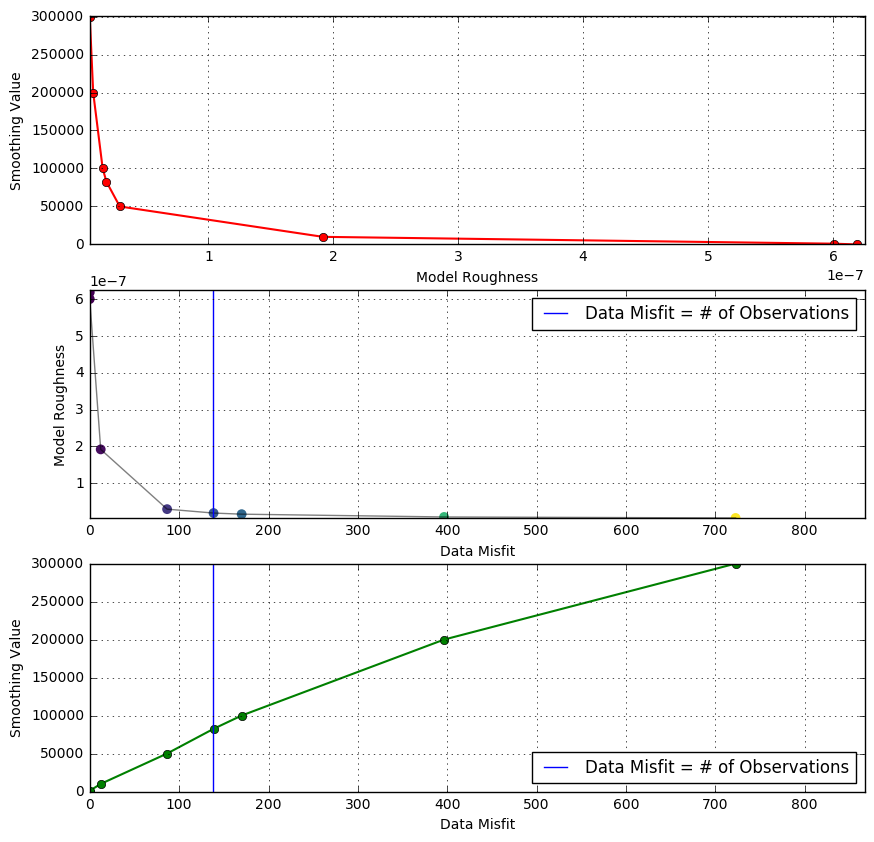

In [17]:
modelRoughness = []
misFit = []

for i in range(len(smoothingVals)):
    modelRoughness.append(np.sum(((smoother @ modelSmoothed[i])**2)))
    misFit.append(np.sum((data_weighted - (A_weighted @ (modelSmoothed[i])))**2))
   

 #plot the results    
fig, ax = plt.subplots(3,1, figsize=(10,10))

ax[0].plot(modelRoughness, smoothingVals, marker='o', c='r', linewidth='1.5')
ax[0].set_xlim([np.amin(modelRoughness)*0.999,np.amax(modelRoughness)*1.01])
ax[0].set_ylim([np.amin(smoothingVals),np.amax(smoothingVals)+50])
ax[0].grid(which='both')
ax[0].set_ylabel('Smoothing Value')
ax[0].set_xlabel('Model Roughness')

ax[1].scatter(misFit,modelRoughness, c=smoothingVals, s=50, cmap='viridis', edgecolor='none')
ax[1].plot(misFit,modelRoughness, alpha=0.5, c='black')
ax[1].axvline(x=len(data), label='Data Misfit = # of Observations')
ax[1].legend()
ax[1].set_ylim([np.amin(modelRoughness)*0.999,np.amax(modelRoughness)*1.01])
ax[1].set_xlim([np.amin(misFit)*0.8,np.amax(misFit)*1.2])
ax[1].grid(which='both')
ax[1].set_xlabel('Data Misfit')
ax[1].set_ylabel('Model Roughness')

ax[2].plot(misFit, smoothingVals, marker='o', c='g', linewidth='1.5')
ax[2].axvline(x=len(data), label='Data Misfit = # of Observations')
ax[2].legend(loc='lower right')
ax[2].set_xlim([np.amin(misFit)*0.8,np.amax(misFit)*1.2])
ax[2].set_ylim([np.amin(smoothingVals),np.amax(smoothingVals)+50])
ax[2].grid(which='both')
ax[2].set_ylabel('Smoothing Value')
ax[2].set_xlabel('Data Misfit')

plt.show()

Looking at the above graphs, it can be seen that as the amount of smoothing decreases, the resultant model becomes rougher and more complex (red curve); however, this decrease in smoothing also leads to a better match of the data serving to decrease the misfit.  Ideally, the correct smoothing weight would provide a model that best balances fitting the data while also remaining as smooth and simple as possible.  Another way of saying this is that we want to fit as much signal as possible (keep the misfit low) while simultaneously minimize the fitting of noise (leading to a rougher model).  This point of switching from fitting signal to fitting noise can be seen as the change of slope on the middle graph above - the change is represented by the transition from a smoother model to rougher model as the data misfit is continuously reduced down the x-axis towards the origin.  

Also, since the error here is well defined, the expected misfit of each data point is 1, meaning that the sum of squared errors should be equal to the number of data points.  Thus, since the model should only be fit within the error, the ideal weighting should occur when the misfit is equal to the number of data points.  The blue line on the bottom two plots above represent this misfit value, and as can be seen on the middle graph, lies approximately at the change in slope where the transition from fitting signal to fitting noise occurs.

Using the last plot (green line), a smoothing value of ~85,000 appears to give the best possible balance between misfit and smoothness.  This is the value that will be used in the final inversion below.

## Final Inversion

In [18]:
#set up damping, flattening, and smoothing matrices
#final values of D = 0.01/F =0.08 of final smoothing value 85,000
damping = 0.01*85000*np.identity(len(A[0,:]))
weightedFlatt = 0.08*85000*flattener
weightedSmooth = 85000*smoother
    
augA = np.concatenate((A_weighted,damping,weightedFlatt,weightedSmooth))

#set up initial model with weighting and create smoothing/flattening 'zero' matrices
dampingModel = 0.01*85000*initVelmod*np.ones((len(A[0,:]),1))
flattTrend = np.zeros((len(flattener),1))
smoothTrend = np.zeros((len(smoother),1))
    
augD = np.concatenate((data_weighted,dampingModel,flattTrend,smoothTrend))

#invert; note that lstsq returns several values - solution contained in the first 
ans = np.linalg.lstsq(augA,augD)
modelSmoothedFinal = ans[0]

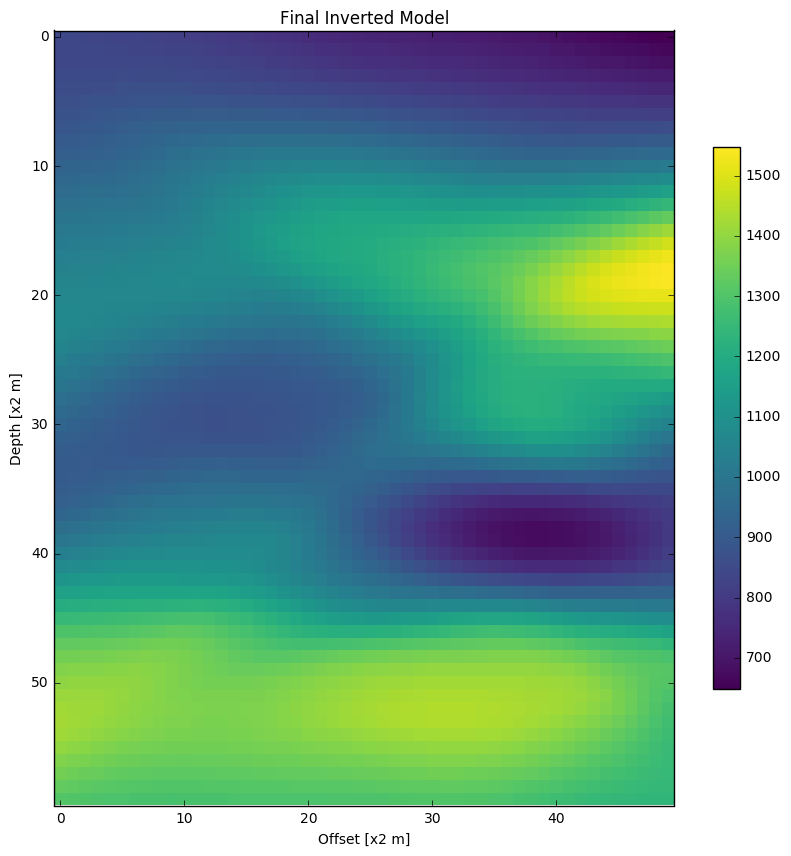

In [19]:
#plot the resulting model
fig, ax = plt.subplots(1,1,figsize=(10,10))

im = ax.imshow(np.reshape(1/modelSmoothedFinal,(60,50)), cmap='viridis', interpolation='None', aspect='auto')
fig.colorbar(im, ax = ax, shrink=0.7)
ax.set_xlabel('Offset [x2 m]')
ax.set_ylabel('Depth [x2 m]')
ax.set_title('Final Inverted Model')

   
plt.show()

The final inverted model can be seen plotted above using a perceptually uniform color map to properly honor the sequential nature of the data.  Looking at the plot, it can be seen that the subsurface velocity generally tends to increase with depth which is to be expected.  There are also several apparent structures present including a high velocity anomaly centered around 36 meters of depth with a wedge like shape, which is underlain by a much slower anomaly around 70 meters of depth at an offset centered at 80 meters.  The base of the recovered model also has a sharp jump in velocity at the base beginning at around 100 meters of depth.  All main anomalies can be seen on the plot below.  

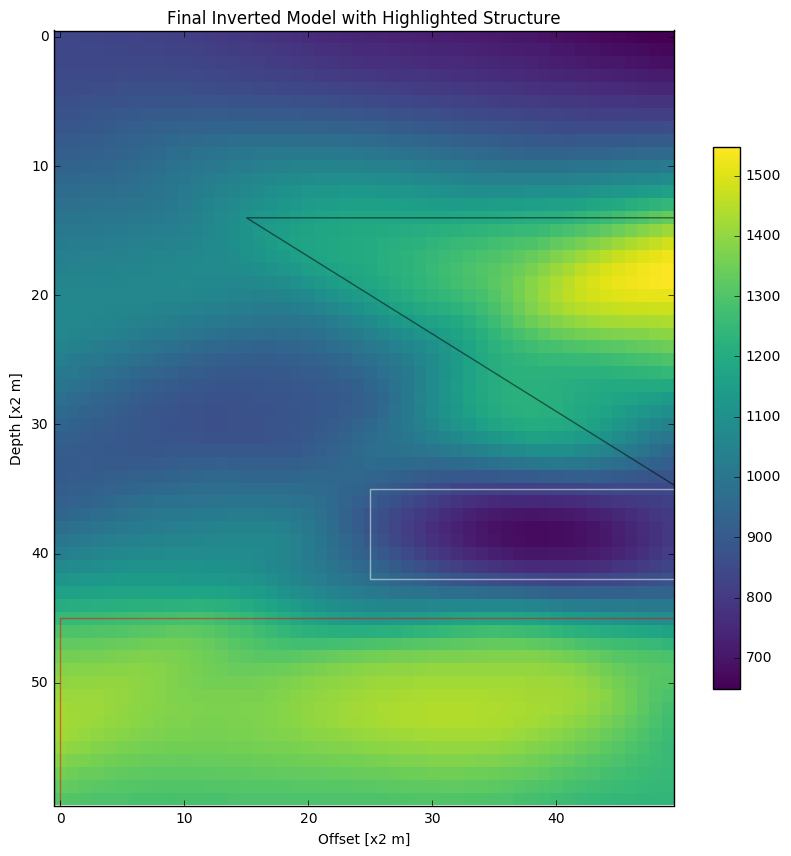

In [20]:
#create interpreted model
import matplotlib.patches as mpaches

#plot the resulting model
fig, ax = plt.subplots(1,1,figsize=(10,10))

im = ax.imshow(np.reshape(1/modelSmoothedFinal,(60,50)), cmap='viridis', interpolation='None', aspect='auto')
fig.colorbar(im, ax = ax, shrink=0.7)
ax.set_xlabel('Offset [x2 m]')
ax.set_ylabel('Depth [x2 m]')
ax.set_title('Final Inverted Model with Highlighted Structure')

velAnom1 = mpaches.Polygon(np.array([[50,14],[15,14],[50,35]]), facecolor='none', alpha=0.5)
velAnom2 = mpaches.Polygon(np.array([[50,35],[25,35],[25,42],[50,42]]), facecolor='none', alpha=0.5, edgecolor='w')
velAnom3 = mpaches.Polygon(np.array([[0,45],[0,60],[50,60],[50,45]]), facecolor='none', alpha=0.5, edgecolor='r')

ax.add_patch(velAnom1)
ax.add_patch(velAnom2)
ax.add_patch(velAnom3)
   
plt.show()

## Resolution Matrix
The last step is to investigate the resolution matrix for the final model.

As stated above, the resolution matrix can be obtained by the following:

$R=(B^TB)^{-1}A^TW_D^{-1}W_DA$

In [21]:
#create 'B' matrix using final selected regularization weights
finalSmoothConst = 100
damping = 0.01*finalSmoothConst*np.identity(len(A[0,:]))
Flatt = 0.025*finalSmoothConst*flattener
Smooth = finalSmoothConst*smoother

B = np.concatenate((A_weighted,damping,Flatt,Smooth))

Res = np.linalg.inv(B.T @ B) @ A.T @ dataWeighting.T @ dataWeighting @ A

print('The shape of the resolution matrix is: ', np.shape(Res))

The shape of the resolution matrix is:  (3000, 3000)


With the resolution matrix obtained, it can be plotted:

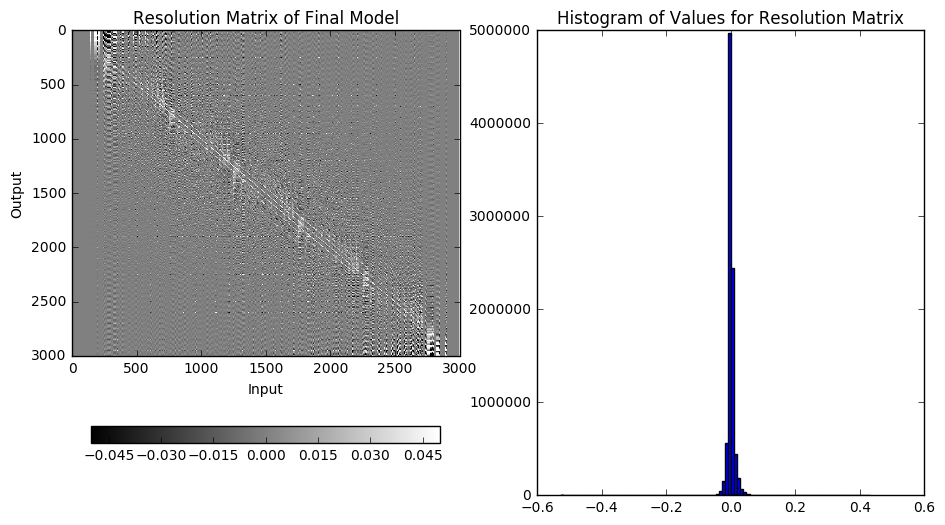

In [22]:
fig, ax = plt.subplots(1,2, figsize=(11,6))
img = ax[0].imshow(Res, cmap='gray', interpolation='None', clim=(-0.05,0.05), aspect='auto')
ax[0].set_title('Resolution Matrix of Final Model')
ax[0].set_xlabel('Input')
ax[0].set_ylabel('Output')

ax[1].hist(Res.ravel(), bins=100)
ax[1].set_title('Histogram of Values for Resolution Matrix')

fig.colorbar(img, ax = ax[0], shrink=0.9, orientation='horizontal')

plt.show()

Each column of the resolution matrix represents the obtained models response to an impulse at a given model location.  As this is a 2 dimensional problem, the resolution matrix above appears incorrect even though it is not.  In order to properly visualize the model response, individual columns need to be selected and plotted as a grid.

Based on the final model, four columns will be selected and plotted below:

1. 148 - Upper right corner
2. 845 - High velocity anomaly
3. 1890 - Low velocity anomaly
4. 2735 - Bottom right corner

Each column will be plotted using the same dimensions as the model with a diverging color bar normalized to a specified value (guided by the above histogram).

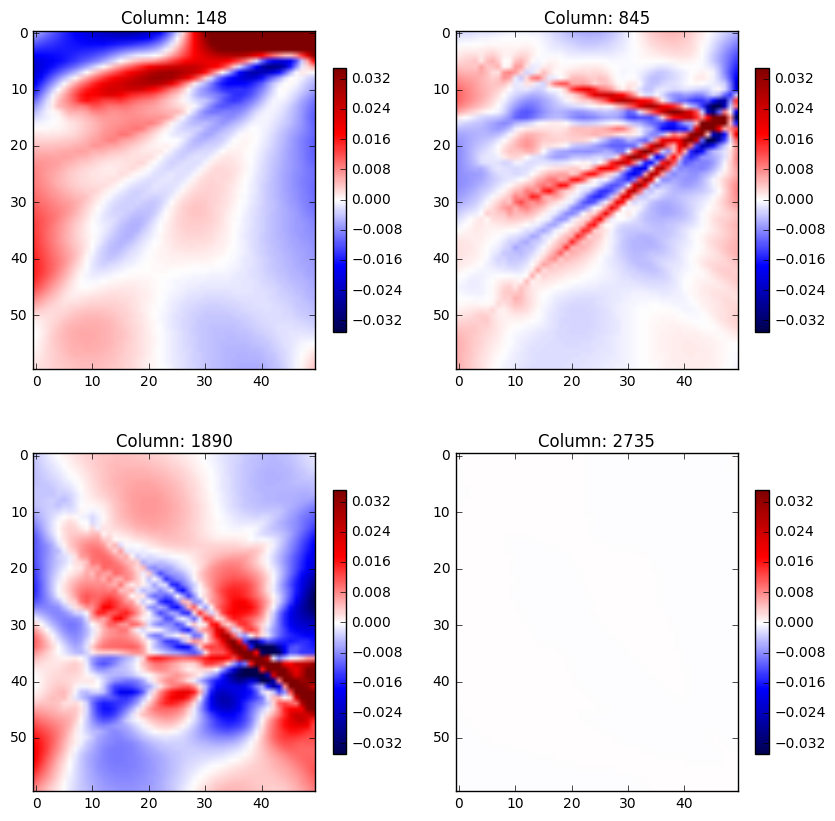

In [23]:
cols_to_plot = [148,845,1890,2735]

fig, ax = plt.subplots(2,2,figsize=(10,10))

i = 0
for row in range(2):
    for col in range(2):
        im = ax[row,col].imshow(np.reshape(Res[:,cols_to_plot[i]],(60,50)), cmap='seismic', vmin=-0.035, vmax=0.035)
        ax[row,col].set_title('Column: %d' %cols_to_plot[i])
        fig.colorbar(im, ax = ax[row,col], shrink=0.75)
        i+=1
    
plt.show()

Looking at the individual column plots above, generalizations about the ability to resolve structure within the model can be made.  Column 148 shows a response that is smeared and not well defined - this is likely due to its location towards the edge of the model and low fold.  Both column 845 and 1890 show well defined and concentrated responses indicating that our ability to detect structure at these locations is high.  Finally, at column 2735, the response is all zero indicating that that portion of the model is totally unresolved. 